In [1]:
# importing packages

import pandas as pd
import numpy as np
import itertools
import pickle
import json
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import mlflow
import mlflow.sklearn
from mlflow import MlflowClient
from mlflow.entities import ViewType

In [2]:
# read data from disk

X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [3]:
# obtaining validation set

X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train_ shape: ', X_train_.shape)
print('y_train_ shape: ', y_train_.shape)
print('X_val shape: ', X_val.shape)
print('y_val shape: ', y_val.shape)

X_train_ shape:  (1105, 21)
y_train_ shape:  (1105, 1)
X_val shape:  (277, 21)
y_val shape:  (277, 1)


In [19]:
# function to evaluate final model against y_test

def evaluate_model(model, test, label_test):
    predicted = model.predict(test)
    print("accuracy:", str(accuracy_score(label_test, predicted)))
    print("precision:", str(precision_score(label_test, predicted, average='weighted')))
    print("recall:", str(recall_score(label_test, predicted, average='weighted')))
    print("f1", str(f1_score(label_test, predicted, average='weighted')))

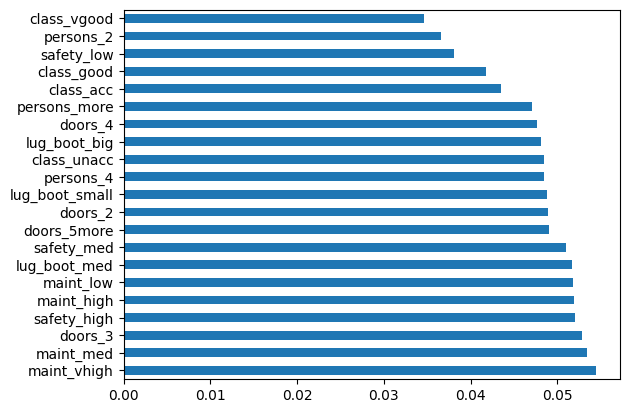

In [5]:
# getting feature importance

reg = ExtraTreesClassifier()
reg.fit(X_train_,y_train_['buying'].ravel())
feat_importances = pd.Series(reg.feature_importances_, index=X_train_.columns)
feat_importances.nlargest(21).plot(kind='barh')
plt.show()

### Hyper-parameter Tuning with MLFlow

In [6]:
# initialise mlflow

mlflow.set_tracking_uri(Path.cwd().joinpath("mlruns"))
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

# Create an experiment name, which must be unique and case sensitive

experiment_id = mlflow.create_experiment(
    "Car Evaluation Experiments",
    artifact_location=Path.cwd().joinpath("mlruns").as_uri(),
    tags={"version": "v1", "priority": "P1"},
)
experiment = mlflow.get_experiment(experiment_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))

Current tracking uri: file:///C:/Users/ongji/Documents/GitHub/Data-Engineer-Tech-Challenge/05_machine_learning/notebooks/mlruns
Name: Car Evaluation Experiments
Experiment_id: 1
Artifact Location: file:///c:/Users/ongji/Documents/GitHub/Data-Engineer-Tech-Challenge/05_machine_learning/notebooks/mlruns
Tags: {'priority': 'P1', 'version': 'v1'}
Lifecycle_stage: active
Creation timestamp: 1664622534076


In [7]:
# get parameter space
def prepare_parameter_space(parameters):
    keys,values = zip(*parameters.items())
    param_experiments = [dict(zip(keys,v)) for v in itertools.product(*values)]

    return param_experiments

# function to run in each hyperparam tuning
def evaluate_rfc_model(params):
    # accesss replicated input data
    X_train_input = X_train_.values
    y_train_input = y_train_.values.ravel()
    X_test_input = X_val.values
    y_test_input = y_val.values.ravel()
    
    for k,v in params.items():
        mlflow.log_param(k, v)
    # instantiate model with parameters
    model = RandomForestClassifier(**params)
    
    # train
    model.fit(X_train_input, y_train_input)
    
    # predict
    y_pred = model.predict(X_test_input)
    
    # score
    model_acc = accuracy_score(y_test_input, y_pred)
    mlflow.log_metric('accuracy', model_acc)  # record actual metric with mlflow run
    mlflow.log_metric('f1_score', f1_score(y_test_input, y_pred, average='weighted'))
    mlflow.log_metric('precision', precision_score(y_test_input, y_pred, average='weighted'))
    mlflow.log_metric('recall', recall_score(y_test_input, y_pred, average='weighted'))
    
    mlflow.sklearn.log_model(model, "models")

In [8]:
rfc_parameters = {'n_estimators': [15,50,100,200],
                'max_features': ['sqrt','log2'],
                'max_depth' : [1,5,9,12],
                'criterion' :['gini','entropy'],
                'random_state': [42]}

search_space = prepare_parameter_space(rfc_parameters)

In [9]:
# start search
with mlflow.start_run(run_name='RFClassifer', experiment_id=experiment.experiment_id):
    for params in search_space:
        with mlflow.start_run(nested=True, experiment_id=experiment.experiment_id):    
            evaluate_rfc_model(params)

c:\Users\ongji\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ongji\anaconda3\envs\machine_learning\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
c:\Users\ongji\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# get best run based on highest accuracy

best_run = MlflowClient().search_runs(
    experiment_ids=experiment.experiment_id,
    filter_string="",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=1,
    order_by=["metrics.accuracy DESC"])[0]

In [11]:
# get best model

final_model = mlflow.sklearn.load_model(f'runs:/{best_run.info.run_id}/models')

In [20]:
# run evaluation

evaluate_model(final_model, X_test, y_test)

accuracy: 0.34104046242774566
precision: 0.43034859018280774
recall: 0.34104046242774566
f1 0.29241850340822484


c:\Users\ongji\anaconda3\envs\machine_learning\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [22]:
# save the model to disk

filename = '../model/rfclassifier.sav'
pickle.dump(final_model, open(filename, 'wb'))